# Dark units (Horvath, KS3)

In [8]:
%load_ext autoreload
%autoreload 2
import os 
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 
import spikeinterface as si
import copy
proj_path = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/"
os.chdir(proj_path)

from src.nodes.postpro.cell_matching import get_SpikeInterface_matching_object
from src.nodes.utils import get_config
from src.nodes.study import bias
from src.nodes.metrics import spike

# set classification parameters
LOW_RATE_CEILING = 0.2  # max firing rate where negative proba change is observed in "bias plot" (sparse units)
DET_THRESH = 0.8
CHANCE_THRESH = 0.1

# spike waveform ms for snr
MS_BEFORE = 3
MS_AFTER = 3

# silico marques
data_conf, param_conf = get_config("silico_horvath", "concatenated/probe_1").values()
SORTING_PATH_m = data_conf["sorting"]["sorters"]["kilosort3"]["output"]
GT_SORTING_PATH_m = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
RECORDING_PATH_m = data_conf["probe_wiring"]["output"]
SORTING_PATH_m = data_conf["sorting"]["sorters"]["kilosort3"]["output"]
STUDY_FOLDER_m = data_conf["postprocessing"]["waveform"]["ground_truth"]["study"]

# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
COLOR_STIM = (0.6, 0.75, 0.1)
BOX_ASPECT = 1                  # square fig
plt.rcParams['figure.figsize'] = (2,1)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['xtick.minor.size'] = 0.1
plt.rcParams['xtick.major.size'] = 1.5
plt.rcParams['ytick.major.size'] = 1.5
plt.rcParams['ytick.major.width'] = 0.3
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True}
# print(plt.rcParams.keys())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-02-16 14:38:57,001 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-16 14:38:57,093 - root - utils.py - get_config - INFO - Reading experiment config. - done


In [9]:
# takes 2 min

# get true/sorted matching object
MatchingObject_m = get_SpikeInterface_matching_object(GT_SORTING_PATH_m, SORTING_PATH_m)

In [10]:
agreem_mx_m = bias.format_agreement_matrix(MatchingObject_m)

In [11]:
# filter the sorted single units

# marques
Sorting_m = si.load_extractor(SORTING_PATH_m)
agreem_mx_m = agreem_mx_m.loc[
    Sorting_m.unit_ids[Sorting_m.get_property("KSLabel") == "good"], :
]

combination of biases: ['oversplit' 'poorly detected']


/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/src/nodes/study/bias.py:247: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


Text(0.5, -31.72881489572491, 'Simulated recordings')

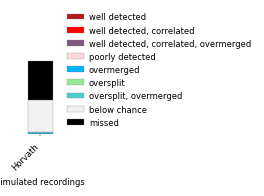

In [12]:
# takes 2 secs

# record agreement matrices for each dataset
agreem_mxs = [agreem_mx_m]
agreem_names = ["Horvath"]

df = pd.DataFrame()

for ix, mx_i in enumerate(agreem_mxs):

    # classify sorting biases for this dataset
    bias_labels = bias.classify_true_unit_biases(mx_i, DET_THRESH, CHANCE_THRESH)

    # calculate proportions of biases for this dataset
    biases_ratio_df = bias.create_true_biases_df(bias_labels)
    df[agreem_names[ix]] = biases_ratio_df["cell_count"].values

df.index = biases_ratio_df.index

# plot
fig, axis = plt.subplots(1, 1, figsize=(0.5, 1))
axis = bias.plot_biases(axis, df)
axis.set_xlabel("Simulated recordings")

### Get all true units features

In [13]:
# takes 10 min

# get ground truth
SortingTrue_m = si.load_extractor(GT_SORTING_PATH_m)

# get signal-to-noise ratio
snrs = spike.get_true_units_SNRs(RECORDING_PATH_m, STUDY_FOLDER_m, MS_BEFORE, MS_AFTER)

# get firing rates
snrs = spike.get_true_units_SNRs(RECORDING_PATH_m, STUDY_FOLDER_m, MS_BEFORE, MS_AFTER)

# get spatial spread
spatial_spread = spike.get_spatial_spread_all_units(
    RECORDING_PATH_m, STUDY_FOLDER_m, MS_BEFORE, MS_AFTER
)

FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/horvath/concatenated_campaigns/probe1_hex0_rou04_pfr03_20Khz/postpro/realism/spike/ground_truth/study/names.txt'

### Sort by missed and detected units

In [196]:
# takes 30 secs

# - get missed true units
# - get well detected true units
# - how do their features significantly differ?

# MISSED UNITS -----------

# get true distances
missed_true_units = bias_labels[bias_labels.values == "missed"].index.tolist()
distances_missed = spike.get_distance_for(
    missed_true_units, SortingTrue_m, RECORDING_PATH_m
)

# get snrs
snrs_missed = [snrs[ix] for ix in missed_true_units]

# get firing rates
firing_rates_missed = spike.get_firing_rates_for(missed_true_units, SortingTrue_m)

# get spatial spread
spread_missed = [spatial_spread[ix] for ix in missed_true_units]

# get layer
layers_missed = spike.get_layer_for(missed_true_units, SortingTrue_m)

# get synapse class
synapse_class_missed = spike.get_synapse_class_for(missed_true_units, SortingTrue_m)

# get synapse class
etype_missed = spike.get_etype_for(missed_true_units, SortingTrue_m)

# get synapse class
mtype_missed = spike.get_mtype_for(missed_true_units, SortingTrue_m)

# WELL DETECTED UNITS -----------

# get true distances
detected_true_units = bias_labels[bias_labels.values == "well detected"].index.tolist()
distances_detected = spike.get_distance_for(
    detected_true_units, SortingTrue_m, RECORDING_PATH_m
)
# get snrs
snrs_detected = [snrs[ix] for ix in detected_true_units]

# get firing rates
firing_rates_detected = spike.get_firing_rates_for(detected_true_units, SortingTrue_m)

# get spatial spread
spread_detected = [spatial_spread[ix] for ix in detected_true_units]

# get layer
layers_detected = spike.get_layer_for(detected_true_units, SortingTrue_m)

# get synapse class
synapse_class_detected = spike.get_synapse_class_for(detected_true_units, SortingTrue_m)

# get etype
etype_detected = spike.get_etype_for(detected_true_units, SortingTrue_m)

# get mtype
mtype_detected = spike.get_mtype_for(detected_true_units, SortingTrue_m)


# CREATE FEATURE DATASET

# missed unit features
missed_data = pd.DataFrame()
missed_data["distance"] = distances_missed
missed_data["snr"] = snrs_missed
missed_data["firing rate"] = firing_rates_missed
missed_data["spread"] = spread_missed
missed_data["layer"] = layers_missed
missed_data["synapse class"] = synapse_class_missed
missed_data["etype"] = etype_missed
missed_data["mtype"] = mtype_missed
missed_data["bias"] = "Missed"

# detected unit features
detected_data = pd.DataFrame()
detected_data["distance"] = distances_detected
detected_data["snr"] = snrs_detected
detected_data["firing rate"] = firing_rates_detected
detected_data["spread"] = spread_detected
detected_data["layer"] = layers_detected
detected_data["synapse class"] = synapse_class_detected
detected_data["etype"] = etype_detected
detected_data["mtype"] = mtype_detected
detected_data["bias"] = "Detected"

# concat for plot
plot_data = pd.concat([missed_data, detected_data], ignore_index=True)

### Plot quantitative features

,distance,snr,firing rate,spread,layer,synapse class,bias
0,11.426037,12.147282,0.003401,433.458738,6,EXC,Missed
1,33.387475,4.458860,0.008503,300.251298,2,EXC,Missed
2,12.050085,12.608667,0.005102,743.127335,6,EXC,Missed
3,5.339407,28.421812,0.006803,534.134566,3,EXC,Missed
4,8.266111,9.085604,0.008503,1386.073124,1,INH,Missed
...,...,...,...,...,...,...,...
240,26.052684,1.778297,1.693878,252.716463,6,INH,Detected
241,28.671510,2.746767,1.926872,479.095856,6,EXC,Detected
242,9.889581,11.653646,0.877551,634.076780,4,EXC,Detected
243,5.956232,27.550940,1.384354,490.034546,5,EXC,Detected


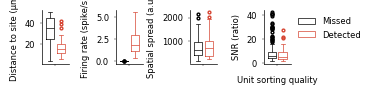

In [185]:
# FORMAT PLOT DATASET
ASPECT_RATIO = 2
GAP = 0.2

display(plot_data)

# PLOT
fig, axes = plt.subplots(1, 4, figsize=(3.5, 0.7))

# DISTANCE

ax = sns.boxplot(
    ax=axes[0],
    data=plot_data,
    hue="bias",
    y="distance",
    fill=False,
    palette=["k", COLOR_SILI],
    gap=GAP,
    linewidth=plt.rcParams["lines.linewidth"],
    flierprops={"marker": ".", "markersize": 4},
)
ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)
ax.set_ylabel("Distance to site (\u03bcm)")
ax.set_box_aspect(ASPECT_RATIO)

# FIRING RATE

ax = sns.boxplot(
    ax=axes[1],
    data=plot_data,
    hue="bias",
    y="firing rate",
    fill=False,
    palette=["k", COLOR_SILI],
    gap=GAP,
    linewidth=plt.rcParams["lines.linewidth"],
    flierprops={"marker": ".", "markersize": 4},
)

ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)
ax.set_ylabel("Firing rate (spike/s)")
ax.set_box_aspect(ASPECT_RATIO)
fig.subplots_adjust(wspace=0.5, hspace=0.1)

# SPREAD

ax = sns.boxplot(
    ax=axes[2],
    data=plot_data,
    hue="bias",
    y="spread",
    fill=False,
    palette=["k", COLOR_SILI],
    gap=GAP,
    linewidth=plt.rcParams["lines.linewidth"],
    flierprops={"marker": ".", "markersize": 4},
)

ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)
ax.set_ylabel("Spatial spread (a.u)")
ax.set_box_aspect(ASPECT_RATIO)
fig.subplots_adjust(wspace=0.5, hspace=0.1)

# SNRS

ax = sns.boxplot(
    ax=axes[3],
    data=plot_data,
    hue="bias",
    y="snr",
    fill=False,
    palette=["k", COLOR_SILI],
    gap=GAP,
    linewidth=plt.rcParams["lines.linewidth"],
    flierprops={"marker": ".", "markersize": 4},
)
ax.set_box_aspect(ASPECT_RATIO)

ax.spines[["top", "right"]].set_visible(False)
ax.legend(frameon=False, loc="upper left", bbox_to_anchor=(1, 1))
ax.set_ylabel("SNR (ratio)")
ax.set_xlabel("Unit sorting quality")
# fig.subplots_adjust(wspace=0.5, hspace=0.1)

# save figures
plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/figures/3_bias/svg/quantitative_portrait_dark_units_horvath_p2_ks3.svg",
    **savefig_cfg,
)

### Plot qualitative features

#### Layer

/tmp/ipykernel_193940/3789931544.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data["layer"][plot_data["layer"] == "2"] = "2/3"
/tmp/ipykernel_193940/3789931544.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data["layer"][plot_data["layer"] == "3"] = "2/3"
/tmp/ipykernel_193940/3789931544.py:42: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(


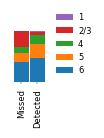

In [186]:
# combine layer 2/3
plot_data["layer"][plot_data["layer"] == "2"] = "2/3"
plot_data["layer"][plot_data["layer"] == "3"] = "2/3"

# format dataset to plot
df = plot_data["layer"][plot_data["bias"] == "Missed"]
df_ratio_missed = df.value_counts(normalize=True)
df_ratio_missed = df_ratio_missed.to_frame()
df_ratio_missed.columns = ["Missed"]

df = plot_data["layer"][plot_data["bias"] == "Detected"]
df_ratio_detected = df.value_counts(normalize=True)
df_ratio_detected = df_ratio_detected.to_frame()
df_ratio_detected.columns = ["Detected"]

# concat for plot
plot_data2 = pd.concat([df_ratio_missed, df_ratio_detected], axis=1)

# reorder layers
plot_data2 = plot_data2.loc[["6", "5", "4", "2/3", "1"]]

fig, axis = plt.subplots(1, 1, figsize=(0.5, 0.7))
ax = (plot_data2).T.plot.bar(
    ax=axis,
    stacked=True,
    # color=colors,
    width=0.9,
    edgecolor="none",
    linewidth=0.2,
)

# set axis legend
ax.spines[["left", "right", "top", "bottom"]].set_visible(False)
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)
ax.set_ylabel("Sorting biases (ratio)", fontsize=9)

hs, ls = ax.get_legend_handles_labels()
hss = [hs[4], hs[3], hs[2], hs[1], hs[0]]
lss = [ls[4], ls[3], ls[2], ls[1], ls[0]]

ax.legend(
    plot_data2.index,
    ncol=1,
    loc="lower left",
    bbox_to_anchor=(1, 0),
    frameon=False,
    handletextpad=0.6,
    handles=hss,
    labels=lss,
)

# save figures
plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/figures/3_bias/svg/portrait_layer_dark_units_horvath_p2_ks3.svg",
    **savefig_cfg,
)

#### Synapse class (inh/exc)

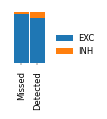

In [193]:
# colors = (0, 0, 0, ())

# format dataset to plot
df = plot_data["synapse class"][plot_data["bias"] == "Missed"]
df_ratio_missed = df.value_counts(normalize=True)
df_ratio_missed = df_ratio_missed.to_frame()
df_ratio_missed.columns = ["Missed"]

df = plot_data["synapse class"][plot_data["bias"] == "Detected"]
df_ratio_detected = df.value_counts(normalize=True)
df_ratio_detected = df_ratio_detected.to_frame()
df_ratio_detected.columns = ["Detected"]

# concat for plot
plot_data3 = pd.concat([df_ratio_missed, df_ratio_detected], axis=1)

# reorder synapse class
# plot_data3 = plot_data3.loc[["6", "5", "4", "2/3", "1"]]

fig, axis = plt.subplots(1, 1, figsize=(0.5, 0.7))
ax = (plot_data3).T.plot.bar(
    ax=axis,
    stacked=True,
    # color=colors,
    width=0.9,
    edgecolor="none",
    linewidth=0.2,
)

# set axis legend
ax.spines[["left", "right", "top", "bottom"]].set_visible(False)
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)
ax.set_ylabel("Sorting biases (ratio)", fontsize=9)

# hs, ls = ax.get_legend_handles_labels()
# hss = [hs[4], hs[3], hs[2], hs[1], hs[0]]
# lss = [ls[4], ls[3], ls[2], ls[1], ls[0]]

ax.legend(
    plot_data3.index,
    ncol=1,
    loc="lower left",
    bbox_to_anchor=(1, 0),
    frameon=False,
    handletextpad=0.6,
    # handles=hss,
    # labels=lss,
)

# save figures
plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/figures/3_bias/svg/portrait_synapse_dark_units_horvath_p2_ks3.svg",
    **savefig_cfg,
)

### etype

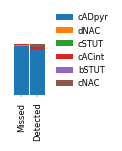

In [197]:
# format dataset to plot
df = plot_data["etype"][plot_data["bias"] == "Missed"]
df_ratio_missed = df.value_counts(normalize=True)
df_ratio_missed = df_ratio_missed.to_frame()
df_ratio_missed.columns = ["Missed"]

df = plot_data["etype"][plot_data["bias"] == "Detected"]
df_ratio_detected = df.value_counts(normalize=True)
df_ratio_detected = df_ratio_detected.to_frame()
df_ratio_detected.columns = ["Detected"]

# concat for plot
plot_data3 = pd.concat([df_ratio_missed, df_ratio_detected], axis=1)

# reorder etype
# plot_data3 = plot_data3.loc[["6", "5", "4", "2/3", "1"]]

fig, axis = plt.subplots(1, 1, figsize=(0.5, 0.7))
ax = (plot_data3).T.plot.bar(
    ax=axis,
    stacked=True,
    # color=colors,
    width=0.9,
    edgecolor="none",
    linewidth=0.2,
)

# set axis legend
ax.spines[["left", "right", "top", "bottom"]].set_visible(False)
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)
ax.set_ylabel("Sorting biases (ratio)", fontsize=9)

# hs, ls = ax.get_legend_handles_labels()
# hss = [hs[4], hs[3], hs[2], hs[1], hs[0]]
# lss = [ls[4], ls[3], ls[2], ls[1], ls[0]]

ax.legend(
    plot_data3.index,
    ncol=1,
    loc="lower left",
    bbox_to_anchor=(1, 0),
    frameon=False,
    handletextpad=0.6,
    # handles=hss,
    # labels=lss,
)

# save figures
plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/figures/3_bias/svg/portrait_etype_dark_units_horvath_p2_ks3.svg",
    **savefig_cfg,
)

### mtype

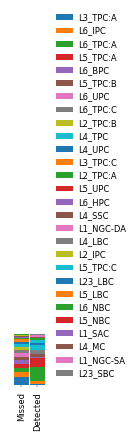

In [198]:
# format dataset to plot
df = plot_data["mtype"][plot_data["bias"] == "Missed"]
df_ratio_missed = df.value_counts(normalize=True)
df_ratio_missed = df_ratio_missed.to_frame()
df_ratio_missed.columns = ["Missed"]

df = plot_data["mtype"][plot_data["bias"] == "Detected"]
df_ratio_detected = df.value_counts(normalize=True)
df_ratio_detected = df_ratio_detected.to_frame()
df_ratio_detected.columns = ["Detected"]

# concat for plot
plot_data3 = pd.concat([df_ratio_missed, df_ratio_detected], axis=1)

# reorder mtype
# plot_data3 = plot_data3.loc[["6", "5", "4", "2/3", "1"]]

fig, axis = plt.subplots(1, 1, figsize=(0.5, 0.7))
ax = (plot_data3).T.plot.bar(
    ax=axis,
    stacked=True,
    # color=colors,
    width=0.9,
    edgecolor="none",
    linewidth=0.2,
)

# set axis legend
ax.spines[["left", "right", "top", "bottom"]].set_visible(False)
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)
ax.set_ylabel("Sorting biases (ratio)", fontsize=9)

# hs, ls = ax.get_legend_handles_labels()
# hss = [hs[4], hs[3], hs[2], hs[1], hs[0]]
# lss = [ls[4], ls[3], ls[2], ls[1], ls[0]]

ax.legend(
    plot_data3.index,
    ncol=1,
    loc="lower left",
    bbox_to_anchor=(1, 0),
    frameon=False,
    handletextpad=0.6,
    # handles=hss,
    # labels=lss,
)

# save figures
plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/figures/3_bias/svg/portrait_mtype_dark_units_horvath_p2_ks3.svg",
    **savefig_cfg,
)